In [239]:
import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from monai.transforms import Activations
from monai.metrics import ROCAUCMetric

from sklearn.metrics import ConfusionMatrixDisplay#, confusion_matrix 
from sklearn import metrics
import sklearn

import misc


In [298]:
def get_predictions_filename(folder_name):
    fold_test_preds_filename, ens_test_preds_filename = None, None
    if "dcnn_lrelu" in folder_name:
        fold_test_preds_filename = "dcnn_lrelu_outputs.csv"
        ens_test_preds_filename = "dcnn_lrelu_ens_outputs.csv"

    return fold_test_preds_filename, ens_test_preds_filename



In [288]:
from torcheval.metrics import MulticlassAUROC, BinaryAUROC, BinaryF1Score, BinaryConfusionMatrix, BinaryAUPRC, BinaryRecall
from torcheval.metrics.functional.classification import binary_recall


def collect_metrics(targets, predictions, thresh, verbose = False):
    # make the predictions binary, by thresholding the predicted probabilities
    preds_binary = torch.round(torch.tensor([1 if p > thresh else 0 for p in predictions])).type(torch.int)

    """
    # precision
    precision_metric = BinaryAUPRC() 
    precision_metric.update(input=preds_binary, target=targets)
    precision_score = precision_metric.compute()
    precision_metric.reset()

    # recall
    recall_metric = BinaryRecall()
    recall_metric.update(input=preds_binary, target=targets)
    recall_score = recall_metric.compute()
    recall_metric.reset()

    # F1-score
    f1_metric = BinaryF1Score()
    f1_metric.update(input=preds_binary, target=targets)
    f1_score = f1_metric.compute()
    f1_metric.reset()
    """

    # AUC
    auc_metric = BinaryAUROC()
    auc_metric.update(input=predictions, target=targets)
    auc_score = auc_metric.compute()
    auc_metric.reset()


    CM = BinaryConfusionMatrix()
    CM.update(input=preds_binary, target=targets)
    cm = CM.compute()
    CM.reset()

    TN = int(cm[0,0].item())
    FP = int(cm[0,1].item())
    FN = int(cm[1,0].item())
    TP = int(cm[1,1].item())

    accuracy_score = (TP + TN) / (TP + TN + FP + FN)
    precision_score = TP / (TP + FP)
    recall_score = TP / (TP + FN)
    specificity = TN / (TN + FP)
    f1_score = (2 * precision_score * recall_score) / (precision_score + recall_score)

    
    if verbose:
        print(f"  accuracy score:      {accuracy_score:.3f}")
        print(f"  precision score:     {precision_score:.3f}")
        print(f"  recall score:        {recall_score:.3f}")
        print(f"  specificity score:   {specificity:.3f}")

        print(f"  f1 score:            {f1_score:.3f}")
        print(f"  AUC score:           {auc_score:.3f}")
        print("  Confusion Matrix:   ")
        print(cm)
        print(" ")
    

    return accuracy_score, precision_score, recall_score, specificity, f1_score, auc_score, cm


In [282]:
experiment_folders = next(os.walk(root))[1]
experiment_folders

['PRETRAINED',
 'pretrain_loss_weights',
 'xero_bce',
 'xero_cv_2',
 'Xero_DCNN_20240111',
 'Xero_DCNN_BinaryOutput_20240111',
 'xero_no_baseline']

20240117_075829_4_0_17_dcnn_lrelu_params_140100_auc_tr_0.764_lr_0.77_val_0.743_lr_0.832_test_0.731_lr_0.747
20240117_075829_4_1_59_dcnn_lrelu_params_140100_auc_tr_0.783_lr_0.771_val_0.792_lr_0.831_test_0.764_lr_0.756
20240117_075829_4_2_47_dcnn_lrelu_params_140100_auc_tr_0.799_lr_0.781_val_0.729_lr_0.723_test_0.765_lr_0.754
20240117_075829_4_3_17_dcnn_lrelu_params_140100_auc_tr_0.761_lr_0.769_val_0.844_lr_0.842_test_0.753_lr_0.756
20240117_075829_4_4_46_dcnn_lrelu_params_140100_auc_tr_0.788_lr_0.78_val_0.758_lr_0.726_test_0.746_lr_0.755
20240117_075829_4_5_16_dcnn_lrelu_params_140100_auc_tr_0.784_lr_0.784_val_0.672_lr_0.707_test_0.766_lr_0.758
20240117_075829_4_6_18_dcnn_lrelu_params_140100_auc_tr_0.746_lr_0.77_val_0.819_lr_0.822_test_0.773_lr_0.752
20240117_075829_4_7_16_dcnn_lrelu_params_140100_auc_tr_0.781_lr_0.78_val_0.761_lr_0.746_test_0.739_lr_0.755
20240117_075829_4_8_5_dcnn_lrelu_params_140100_auc_tr_0.755_lr_0.78_val_0.766_lr_0.741_test_0.79_lr_0.752
20240117_075829_4_9_99_dcn

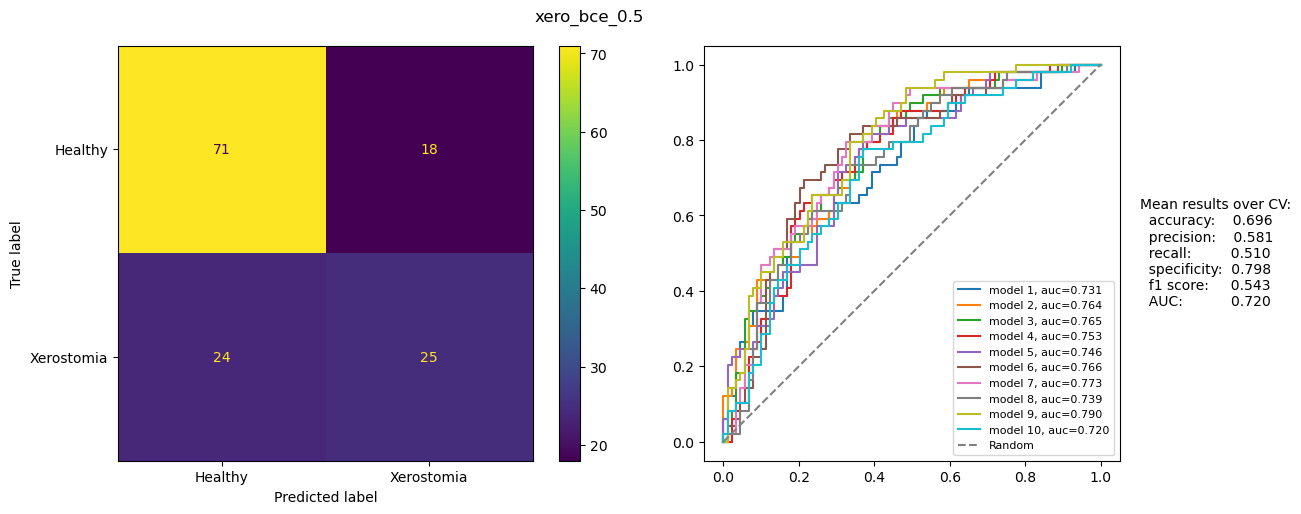

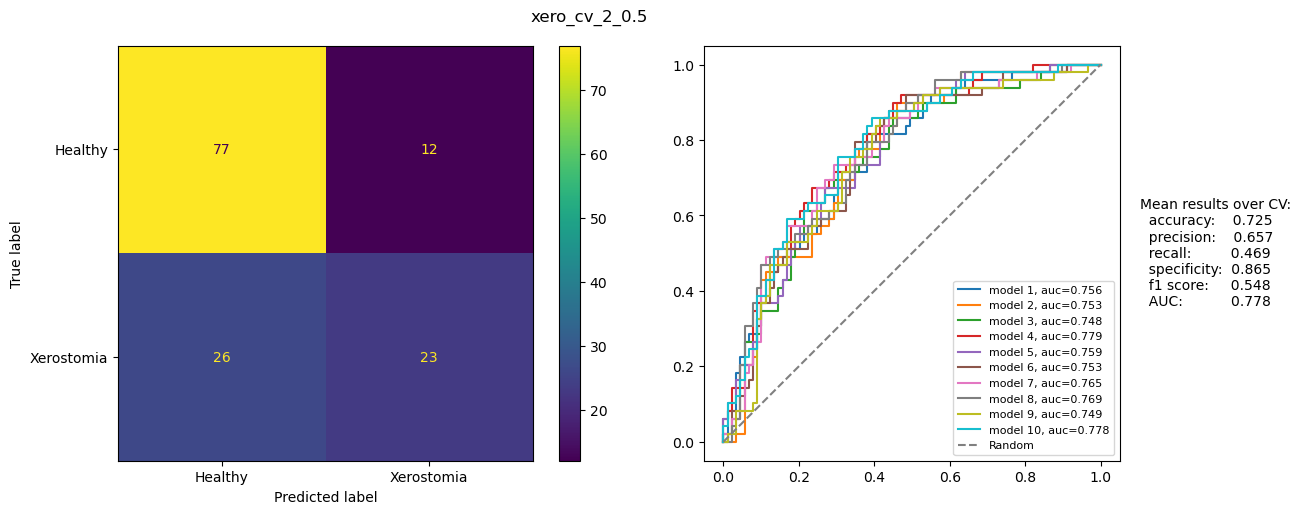

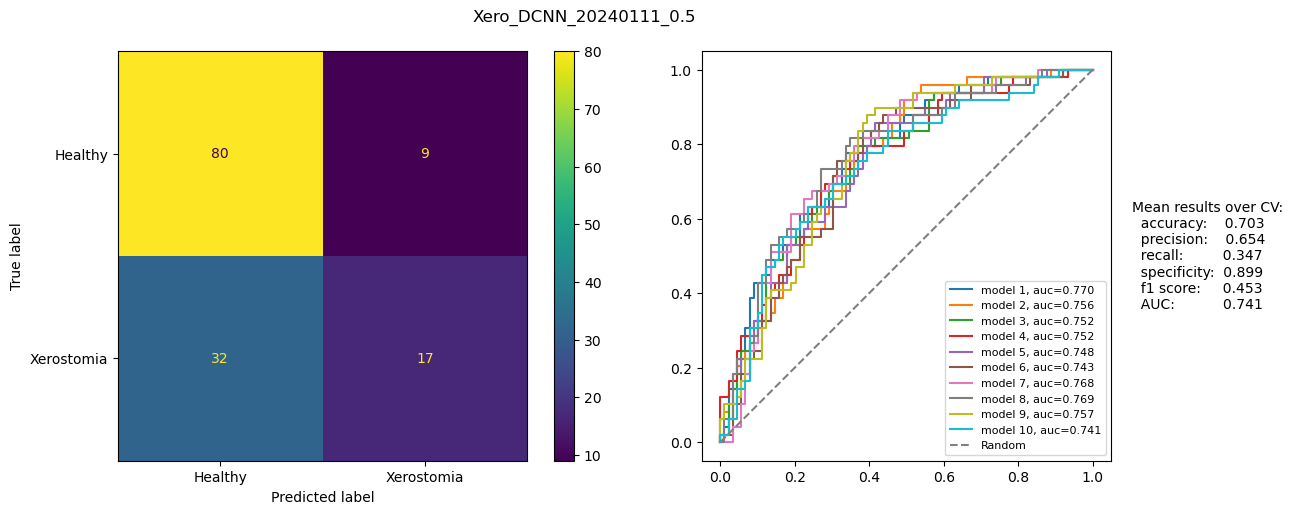

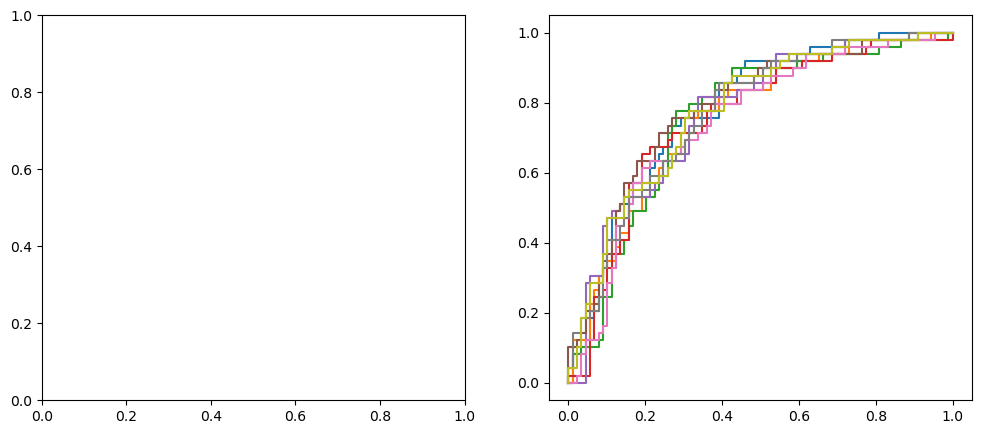

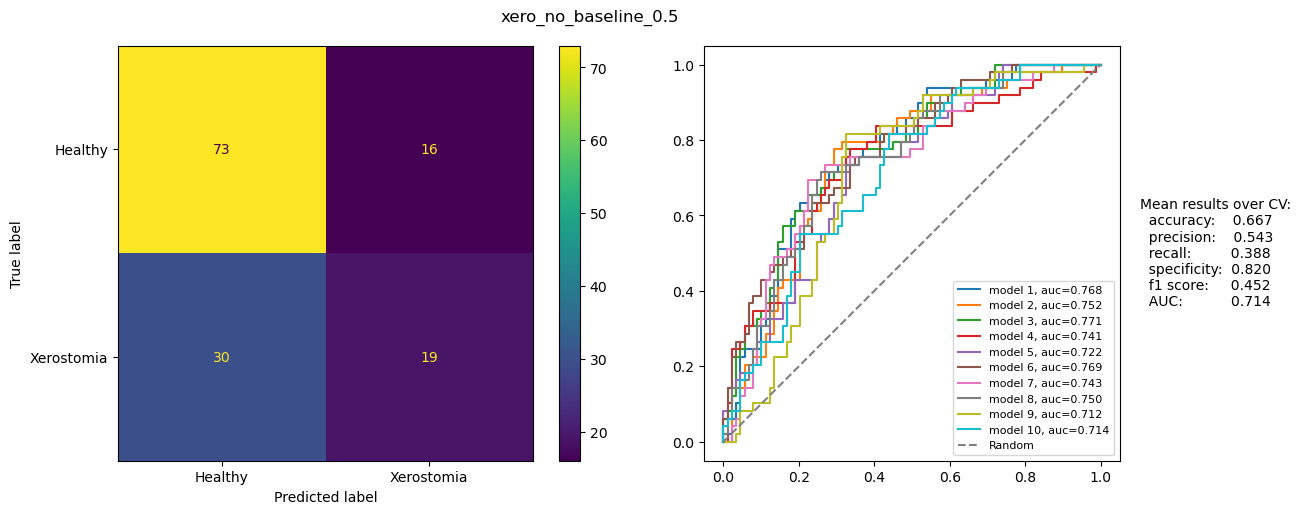

In [297]:
root = "experiments"

#df_results = pd.DataFrame(columns=["exp_name", ""])

experiment_folders = next(os.walk(root))[1]


verbose = False
threshold = 0.5

for experiment_name in experiment_folders:

#experiment_name = "Xero_DCNN_BinaryOutput_20240111"
#experiment_name = "Xero_DCNN_20240111"
#experiment_name="xero_cv_2"
#experiment_name="xero_bce"
#experiment_name="xero_no_baseline"
#experiment_name='xero_no_baseline'
#experiment_name='xero_no_clinical'


    folder_path = os.path.join(root, experiment_name)

    cv_fold_folders = next(os.walk(folder_path))[1] # find all subfolders (each subfolder is a cv fold)


    avg_precision_score, avg_recall_score, avg_f1_score, avg_auc_score, avg_cm = 0,0,0,0, torch.tensor([[0,0],[0,0]]).type(torch.float)

    n_folds = len(cv_fold_folders)


    fig, ax = plt.subplots(1, 2, figsize=(12,5), gridspec_kw={'width_ratios': [1, 1]})

    for idx, cv_folder_name in enumerate(cv_fold_folders):
        if verbose:    print(f"FOLD {idx}")
        # make the filenames
        fold_test_preds_filename, ens_test_preds_filename = get_predictions_filename(cv_folder_name)

        if fold_test_preds_filename == None:
            continue

        preds_file_dir = os.path.join(os.path.join(folder_path, cv_folder_name), fold_test_preds_filename)

        # open the predictions file, get the predictions and true labels out
        df_preds = pd.read_csv(preds_file_dir, delimiter=";")
        preds= list(df_preds['pred_1'])
        y_true = list(df_preds['true_1'])  # again just the second col


        # calculate fpr, fpr, auc, and plot it
        fpr, tpr, thresh = metrics.roc_curve(y_true, preds)  
        auc_score = metrics.roc_auc_score(y_true, preds)
        ax[1].plot(fpr, tpr, label=f"model {idx+1}, auc={auc_score:.3f}")


        targets_binarised =torch.tensor(y_true).type(torch.int)
        tensor_preds_single_col = torch.tensor(preds).type(torch.float)


        accuracy_score, precision_score, recall_score, specificity_score, f1_score, auc_score, cm = collect_metrics(targets_binarised, tensor_preds_single_col, thresh=threshold, verbose=verbose)
        
        #print(cm)
        
        

        #plt.figure(1)
        #plt.plot(tpr, fpr, label=f"AAAHHH {idx}, auc={auc_score:.2f}")


    #print("MEAN RESULTS")
    """
    print(f"  precision score: {avg_precision_score:.3f}")
    print(f"  recall score:    {avg_recall_score:.3f}")
    print(f"  f1 score:        {avg_f1_score:.3f}")
    print(f"  AUC score:       {avg_auc_score:.3f}")
    print("  Confusion Matrix:   ")
    print(avg_cm)
    """

    if ens_test_preds_filename != None:
        preds_file_dir = os.path.join(os.path.join(folder_path, cv_folder_name), ens_test_preds_filename)

        try:

            # open the predictions file, get the predictions and true labels out
            df_ens_preds = pd.read_csv(preds_file_dir, delimiter=";")
            ens_predictions= list(df_preds['pred_1'])
            y_true = list(df_preds['true_1'])
            targets_binarised =torch.tensor(y_true).type(torch.int)
            ens_predictions = torch.tensor(ens_predictions).type(torch.float)



            ens_accuracy, ens_precision, ens_recall, ens_specificity, ens_F1, ens_AUC, ens_cm = collect_metrics(targets_binarised, ens_predictions, thresh=threshold, verbose=verbose)


            ConfusionMatrixDisplay(confusion_matrix=np.array(ens_cm.tolist()),
                                        display_labels=["Healthy", "Xerostomia"]).plot(ax=ax[0])
            #disp.plot()
            display_string = f"Mean results over CV:\n  accuracy:    {ens_accuracy:.3f}\n  precision:    {ens_precision:.3f}\n  recall:         {ens_recall:.3f}\n  specificity:  {ens_specificity:.3f}\n  f1 score:     {ens_F1:.3f}\n  AUC:           {ens_AUC:.3f}"

            fig.text(1.05, 0.5, display_string, horizontalalignment='left', verticalalignment='center', transform=ax[1].transAxes)

            ax[1].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
            # fpr, tpr, thresh = metrics.roc_curve(y_true_binary, list(df_preds['pred_1']))
            # auc = metrics.roc_auc_score(y_true_binary, list(df_preds['pred_1']))
            # 
            fig.suptitle(experiment_name + "_" + str(threshold))
            ax[1].legend(loc='lower right', prop={'size': 8})
            ax[0].set_aspect('equal')
            ax[1].set_aspect('equal')
            plt.tight_layout()
            plt.plot()


            figure_path = os.path.join("results", experiment_name + "_" + str(threshold) + ".png")
            fig.savefig(figure_path, bbox_inches='tight')
        except: pass

In [ ]:
def plot_results(targets_binarised, tensor_preds, output_path):
    accuracy_score, precision_score, recall_score, specificity_score, f1_score, auc_score, cm = collect_metrics(targets_binarised, tensor_preds_single_col, thresh=threshold, verbose=verbose)

    fig, ax = plt.subplots(1, 2, figsize=(12,5), gridspec_kw={'width_ratios': [1, 1]})

    ConfusionMatrixDisplay(confusion_matrix=np.array(ens_cm.tolist()),
                               display_labels=["Healthy", "Xerostomia"]).plot(ax=ax[0])

    display_string = f"Mean results over CV:\n  accuracy:    {ens_accuracy:.3f}\n  precision:    {ens_precision:.3f}\n  recall:         {ens_recall:.3f}\n  specificity:  {ens_specificity:.3f}\n  f1 score:     {ens_F1:.3f}\n  AUC:           {ens_AUC:.3f}"
    
    fig.text(1.05, 0.5, display_string, horizontalalignment='left', verticalalignment='center', transform=ax[1].transAxes)

    ax[1].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')

    fig.suptitle(experiment_name + "_" + str(threshold))
    ax[1].legend(loc='lower right', prop={'size': 8})
    ax[0].set_aspect('equal')
    ax[1].set_aspect('equal')
    plt.tight_layout()
    plt.plot()


    figure_path = os.path.join("results", experiment_name + "_" + str(threshold) + ".png")
    fig.savefig(figure_path, bbox_inches='tight')


In [80]:
ens_predictions = ens_predictions/10
collect_metrics(targets_binarised, torch.tensor(ens_predictions) )

  precision score: 0.584
  recall score:    0.408
  f1 score:        0.500
  AUC score:       0.761
  Confusion Matrix:   
tensor([[78., 11.],
        [29., 20.]])


[tensor(0.5839),
 tensor(0.4082),
 tensor(0.5000),
 tensor(0.7613, dtype=torch.float64),
 tensor([[78., 11.],
         [29., 20.]])]

In [66]:
len(ens_predictions)

1380

In [85]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
from scipy.stats import norm

def calculate_overall_auc_ci(all_model_predictions, targets, n_bootstrap_samples=10000, confidence_level=0.95):
    # Concatenate predictions from all models into a 2D array
    #all_model_predictions = np.vstack(predictions_list).T

    # Calculate the AUC for the original data
    original_auc = roc_auc_score(targets, all_model_predictions)

    # Bootstrap resampling to get a distribution of AUC values
    auc_values = []
    for _ in range(n_bootstrap_samples):
        bootstrap_indices = resample(range(len(targets)), replace=True)
        bootstrap_auc = roc_auc_score(targets[bootstrap_indices], all_model_predictions[bootstrap_indices])
        auc_values.append(bootstrap_auc)

    # Calculate mean and standard error of the bootstrap AUC values
    mean_auc = np.mean(auc_values)
    std_auc = np.std(auc_values)

    # Calculate confidence interval using the normal distribution
    z_value = norm.ppf((1 + confidence_level) / 2)
    lower_bound = mean_auc - z_value * std_auc
    upper_bound = mean_auc + z_value * std_auc

    return {
        'original_auc': original_auc,
        'mean_auc': mean_auc,
        'confidence_interval': (lower_bound, upper_bound)
    }

# Example usage:
# predictions_list is a list of 1D lists, each representing the predictions from a different model
# targets is the 1D list of binary targets
# Ensure that all lists have the same length
# Replace these lists with your actual data
predictions_list = ens_predictions
targets = targets_binarised

result = calculate_overall_auc_ci(predictions_list, targets)
print("Original AUC:", result['original_auc'])
print("Mean AUC:", result['mean_auc'])
print("95% Confidence Interval:", result['confidence_interval'])

Original AUC: 0.7612932813574869
Mean AUC: 0.7610014003476495
95% Confidence Interval: (0.6790206014439334, 0.8429821992513656)


In [10]:
from torch import tensor
#from torchmetrics.classification import BinaryRecall
target = tensor([0, 1, 0, 1, 0, 1])
preds = tensor([0, 0, 1, 1, 0, 1])
#metric = binary_recall()
binary_recall(preds, target)

tensor(0.6667)

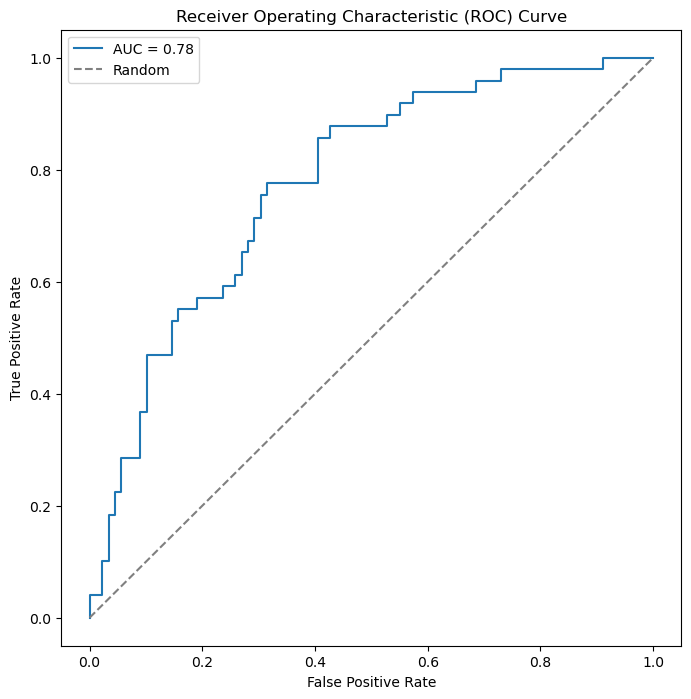

{'Precision': 0.6486486486486487, 'Recall': 0.4897959183673469, 'F1 Score': 0.5581395348837208, 'AUC': 0.7764274249025452}


In [51]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def calculate_classification_metrics(true_labels, predicted_probabilities, threshold=0.5):
    # Convert probabilities to binary predictions based on the threshold
    predicted_labels = [1 if prob >= threshold else 0 for prob in predicted_probabilities]

    # Calculate precision, recall, and F1 score
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    # Calculate AUC and plot ROC curve
    auc = roc_auc_score(true_labels, predicted_probabilities)
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probabilities)

    # Plot ROC curve
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

    # Return metrics
    metrics = {
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': auc
    }

    return metrics

# Example usage:
true_labels = targets_binarised
predicted_probabilities = tensor_preds_single_col

metrics = calculate_classification_metrics(true_labels, predicted_probabilities)
print(metrics)

In [57]:
from sklearn.metrics import classification_report

preds_binary = [int(i > .5) for i in preds_second_col]

print(classification_report(y_true_binary, preds_binary))

              precision    recall  f1-score   support

         0.0       0.75      0.85      0.80        89
         1.0       0.65      0.49      0.56        49

    accuracy                           0.72       138
   macro avg       0.70      0.67      0.68       138
weighted avg       0.72      0.72      0.71       138



In [9]:
auc_metric(tensor_preds, tensor_y_true)
auc_value = auc_metric.aggregate()
print(auc_value)
auc_metric.reset()

TypeError: 'BinaryAUROC' object is not callable

In [99]:
tensor_preds_binary = [torch.as_tensor(x) for x in preds_binary]
tensor_y_true_binary = [torch.as_tensor(x) for x in y_true_binary]

auc_metric(tensor_preds_binary, tensor_y_true_binary)
auc_value = auc_metric.aggregate()
print(auc_value)
auc_metric.reset()

0.622907590002293


In [108]:
#acc = metrics.f1_score(y_true_binary, preds)
sklearn.metrics.roc_auc_score(y_true_binary, list(df_preds['pred_1']))


0.741343728502637

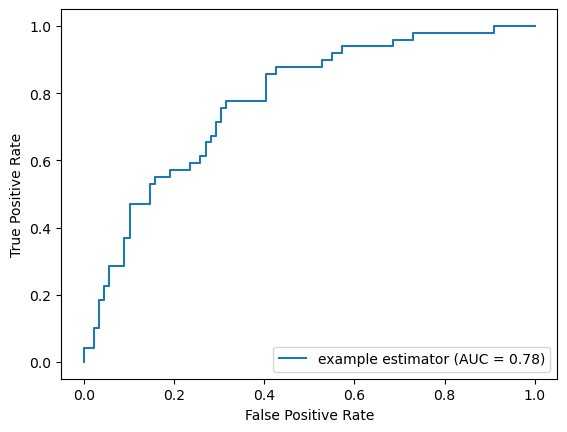

In [96]:

fpr, tpr, thresholds = metrics.roc_curve(y_true_binary, list(df_preds['pred_1']))
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
display.plot()
plt.show()

In [150]:
ens_file_dir = "experiments/Xero_DCNN_20240111/20240110_152732_4_9_16_dcnn_lrelu_params_140144_auc_tr_0.782_lr_0.778_val_0.715_lr_0.751_test_0.741_lr_0.752/dcnn_lrelu_ens_outputs.csv"

df_ens_preds = pd.read_csv(ens_file_dir, delimiter=";")
#print(df_preds.head())

ens_preds = [list(row) for row in zip(df_ens_preds['pred_0'], df_ens_preds['pred_1'])]
ens_preds_binary = [1 if p2 > p1 else 0 for [p1,p2] in preds]

ens_y_true = [list(row) for row in zip(df_ens_preds['true_0'], df_ens_preds['true_1'])]
ens_y_true_binary = list(df_ens_preds['true_1'])

metrics.roc_auc_score(ens_y_true_binary, list(df_ens_preds['pred_1']), average='macro')

0.7612932813574869

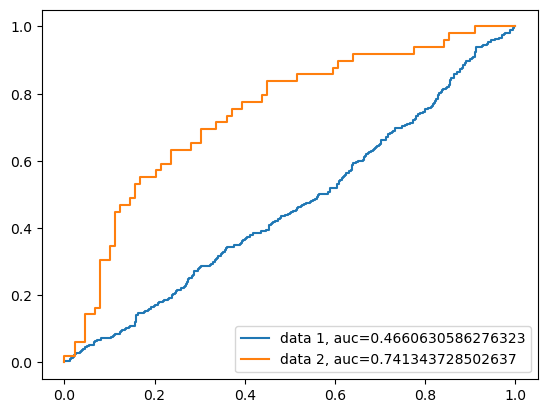

In [106]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

plt.figure(0).clf()

pred = np.random.rand(1000)
label = np.random.randint(2, size=1000)
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(y_true_binary, list(df_preds['pred_1']))
auc = metrics.roc_auc_score(y_true_binary, list(df_preds['pred_1']))
plt.plot(fpr,tpr,label="data 2, auc="+str(auc))

plt.legend(loc=0)